## HW 3 

In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf
import scipy.optimize as sco

In [46]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [47]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [48]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [49]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:,np.newaxis]

In [50]:
  portf_rtns = np.dot(weights,avg_returns)

  portf_vol = []
  for i in range(0, len(weights)): 
      portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                      np.dot(cov_mat, weights[i]))))
  

  portf_vol = np.array(portf_vol) 
  portf_sharpe_ratio = portf_rtns / portf_vol 

In [51]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

portf_results_df 

,returns,volatility,sharpe_ratio
0,-0.041840,0.229741,-0.182118
1,-0.032099,0.250965,-0.127902
2,-0.052787,0.232481,-0.227058
3,0.101937,0.262020,0.389045
4,-0.038378,0.251882,-0.152365
...,...,...,...
99995,0.061836,0.245997,0.251370
99996,0.049962,0.250287,0.199618
99997,-0.048928,0.229516,-0.213178
99998,0.050206,0.256901,0.195430


In [52]:
N_POINTS = 100 
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS): 
    if portf_rtns_ef[point_index] not in portf_rtns: 
         indices_to_skip.append(point_index) 
         continue 
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index]) 
    # return elements chosen from x or y depending on condition
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

In [53]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)

max_sharpe_portf = portf_results_df.loc[max_sharpe_ind] 

min_vol_ind = np.argmin(portf_results_df.volatility)

min_vol_portf = portf_results_df.loc[min_vol_ind]

In [54]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

In [55]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

## HW 4


In [57]:
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['lines.linewidth'] = 1
warnings.simplefilter(action='ignore', category=FutureWarning)

In [58]:
RISKY_ASSET = 'MSFT'
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['lines.linewidth'] = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

In [59]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 250 rows of data.


In [60]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

In [61]:
train = returns['2018-01-01':'2018-11-30']
test = returns['2018-12-01':'2018-12-31']

In [62]:
T = len(test)
N = len(test) 
s_0 = adj_close[train.index[-1]]
N_SIM = 100 
mu = train.mean()
sigma = train.std()

In [63]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):

    np.random.seed(random_seed)

    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [64]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

In [65]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

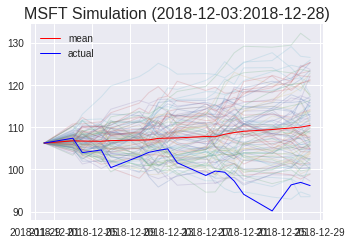

In [66]:

ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()